## Importing libraries

In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.dask

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight
from sklearn import metrics

import scipy

import dask
import dask.dataframe as dd
import dask.array as da
from dask.distributed import Client, SSHCluster
import dask.distributed

import dask_ml
from dask_ml.model_selection import train_test_split
from dask_ml.preprocessing import LabelEncoder

import xgboost as xgb

import mpl_scatter_density
import matplotlib.colors as colors

import csv

## Setting up the cluster

In [140]:
#cluster.close()

In [141]:
cluster = SSHCluster(["bhbh-1", "bhbh-1", "bhbh-2", "bhbh-3", "bhbh-4", "bhbh-5"],
                    connect_options={"client_keys": "/home/ubuntu/private/tbertola_key.pem"},
                    worker_options={"n_workers": 4,
                                    "nthreads": 1}, # because each bhbh-* has 4 cores
                    scheduler_options={"port": 8786, "dashboard_address": ":8787"}
                    )

2023-06-27 16:50:50,910 - distributed.deploy.ssh - INFO - 2023-06-27 16:50:50,906 - distributed.scheduler - INFO - State start
2023-06-27 16:50:50,972 - distributed.deploy.ssh - INFO - 2023-06-27 16:50:50,970 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-27 16:50:51,926 - distributed.deploy.ssh - INFO - 2023-06-27 16:50:51,923 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.21:33451'
2023-06-27 16:50:51,933 - distributed.deploy.ssh - INFO - 2023-06-27 16:50:51,928 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.21:35885'
2023-06-27 16:50:51,934 - distributed.deploy.ssh - INFO - 2023-06-27 16:50:51,931 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.21:37733'
2023-06-27 16:50:51,939 - distributed.deploy.ssh - INFO - 2023-06-27 16:50:51,933 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.21:39557'
2023-06-27 16:50:52,076 - distributed.deploy.ssh - INFO - 2023-06-27 16:

In [142]:
client=Client(cluster)

/home/ubuntu/miniconda3/lib/python3.10/site-packages/distributed/client.py:1388: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+---------+
| Package | Client | Scheduler | Workers |
+---------+--------+-----------+---------+
| tornado | 6.3.2  | 6.3.2     | 6.2     |
+---------+--------+-----------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


In [143]:
client

<Client: 'tcp://10.67.22.140:8786' processes=12 threads=12, memory=23.27 GiB>

## Data

In [144]:
#defin the value of q to drop
q_drop = 0.2

#import data
bhbh = dd.read_parquet('/home/ubuntu/data/bag_all_dataset_with_no_kick/*')

#Masking on the data
bhbh = bhbh[bhbh['q'] > q_drop] #dropping the value of q under q_drop
#bhbh = bhbh[ bhbh['No_Kick'] == 2] #taking only the binaries without kick

## Discretizing and introducing labels

In [145]:
#add column label
n_bins = 100
# Define the edges between bins
counts, bin_edges = da.histogram(bhbh.q.values, bins=n_bins, range=(q_drop,1.0))

# pd.cut each column, with each bin closed on left and open on right
bhbh['label'] = bhbh['q'].map_partitions(pd.cut, bin_edges, right=True, labels=False, include_lowest=False)

## Splitting the data in train and set

In [146]:
bhbh_train, bhbh_test = train_test_split(bhbh, train_size=0.7, shuffle=True)

bhbh_train = bhbh_train.reset_index(drop=True) # just for simplicity sake in the final visualisation
bhbh_test = bhbh_test.reset_index(drop=True)   # and so that we don't mess up later when checking the results

#Repartition for xgboost
bhbh_train = bhbh_train#.repartition(240)

## Sample weigths

In [147]:
countings = bhbh_train['label'].to_frame().groupby('label').size().compute()
total_counts = countings.sum()

#Assign to a new column
def assign_weight(i):
    return np.log(total_counts/(n_bins*countings[i])+1) 

bhbh_train['weight'] = bhbh_train['label'].map(assign_weight)

## Plot of weights respect to labels

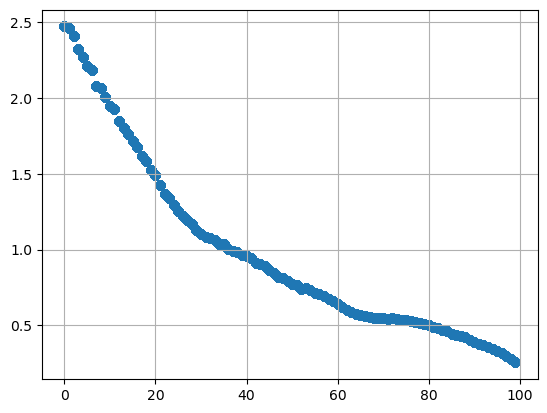

In [148]:
plt.scatter(bhbh_train['label'], bhbh_train['weight'])
plt.grid()
plt.show()

## Rename of useful columns

In [149]:
#training
weights = bhbh_train['weight']
labels = bhbh_train['label']
features = bhbh_train[['Mass_0', 'Z_0', 'Mass_1',  'a', 'e', 'alpha']]

#test
features_test = bhbh_test[['Mass_0', 'Z_0', 'Mass_1',  'a', 'e', 'alpha']]
label_test = bhbh_test['label']

## Consistency of partitions

In [150]:
print('Consistency check')
print('features:', type(features), features.npartitions)

print('label', type(labels), labels.npartitions)
print('weight', type(weights), weights.npartitions)

Consistency check
features: <class 'dask.dataframe.core.DataFrame'> 1800
label <class 'dask.dataframe.core.Series'> 1800
weight <class 'dask.dataframe.core.Series'> 1800


## XGBoost

## Saving and loading the trained model

In [151]:
bst = xgb.Booster()
bst.load_model('bst0_400_w.json')

## Prediction on test

In [152]:
## distributions of the probability of each class for each record

In [153]:
output_test = xgb.dask.predict(client, bst, features_test).persist() #already a dataframe

In [154]:
## Predicition of the label with Maximum estimation

In [155]:
predicted_label = output_test.idxmax(axis=1).persist()

In [156]:
## Computing the true labels and the predicted

In [157]:
Y_test = label_test.values.compute()

In [158]:
Y_predicted = predicted_label.values.compute()

## Scatter Plot with density

In [159]:
def using_mpl_scatter_density(fig, x, y):
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
    density = ax.scatter_density(x, y, cmap='Reds',
                                 norm=colors.LogNorm(vmin=1, vmax=1000))
    fig.colorbar(density, label='Number of points per pixel')

/home/ubuntu/miniconda3/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/ubuntu/miniconda3/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


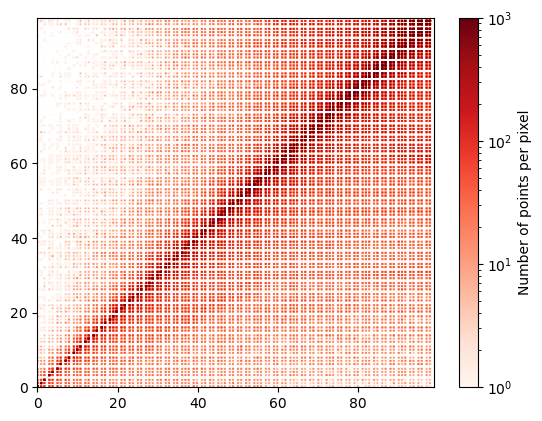

In [160]:
fig = plt.figure()
using_mpl_scatter_density(fig, Y_test, Y_predicted)
plt.show()

## Histogram of the q distribution

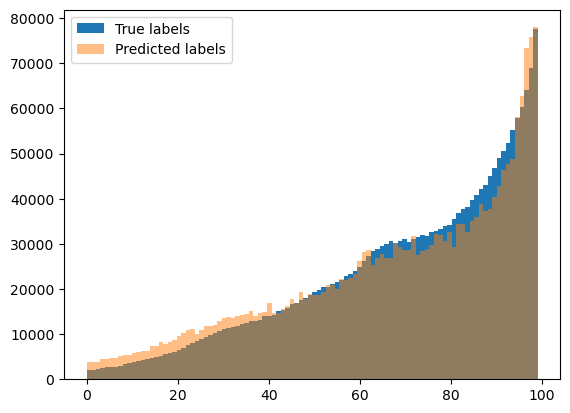

In [161]:
plt.hist(Y_test, bins=n_bins, label = 'True labels')
plt.hist(Y_predicted, bins=n_bins, alpha=0.5, label='Predicted labels')
plt.legend()

## Kulback-Leibler metrics

In [162]:
counts_test, _ = np.histogram(Y_test, density=True, bins=n_bins)
counts_predicted, _ = np.histogram(Y_predicted, density=True, bins=n_bins)

In [163]:
KL_div = scipy.stats.entropy(counts_predicted, counts_test)

In [164]:
KL_div

0.01048458259078654

## Histogram of difference of true and prediction

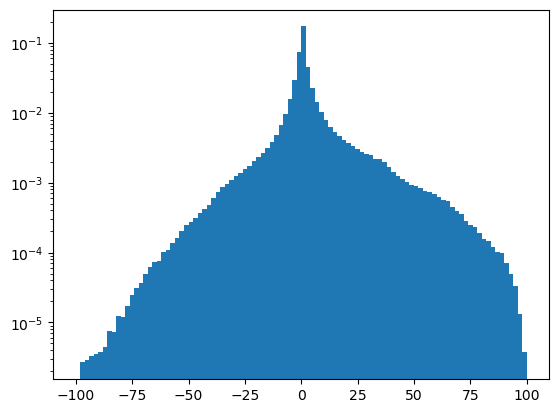

In [165]:
plt.hist(Y_test-Y_predicted, bins=n_bins, density=True, log=True, range=(-n_bins, n_bins))
plt.show()

## Misura della accuracy

In [166]:
## Defining a prediction accurate if not further from the true of a value of threshold
def accuracy_threshold(Y_test, Y_predicted, threshold = 5):
    out=np.abs(Y_test-Y_predicted)
    mask = out < threshold
    return np.sum(mask)/len(Y_test)

In [167]:
accuracy_threshold(Y_test, Y_predicted, 13)

0.8307441301777202

In [168]:
def accuracy_exponential(Y_test, Y_predicted, threshold = 25, tau = 25):
    out = np.exp(-np.abs(Y_test-Y_predicted)/tau)
    out = out[np.abs(Y_test-Y_predicted)<threshold]
    return np.sum(out)/len(Y_test)

In [169]:
accuracy_exponential(Y_test, Y_predicted)

0.7981704268227776

## Grid Search with For Loops

## Clustering of probability distribution

In [170]:
# Defininf a function to order the peaks of the probability distribution
def extract_top_values(row, n_top=3):
    row_sorted = np.sort(row)[::-1]
    return row_sorted[:n_top]

In [172]:
# applying the previous function
top_values = output_test.apply(extract_top_values, axis=1, meta=(None, 'object'))

## Creating a dataframe with all the test set information

In [173]:
top_values =top_values.compute()
top_values = pd.DataFrame(top_values.to_list(), columns = ['1', '2', '3'])

In [174]:
top_values['Y_predicted']=Y_predicted
top_values['Y_test']=Y_test
top_values['Delta_Y']=np.abs(Y_predicted-Y_test)

In [175]:
X_test = features_test.compute()

In [176]:
for col in X_test.columns:
    top_values[col]=X_test[col].values

## Some interesting representations

## All the points

<Axes: xlabel='1', ylabel='2'>

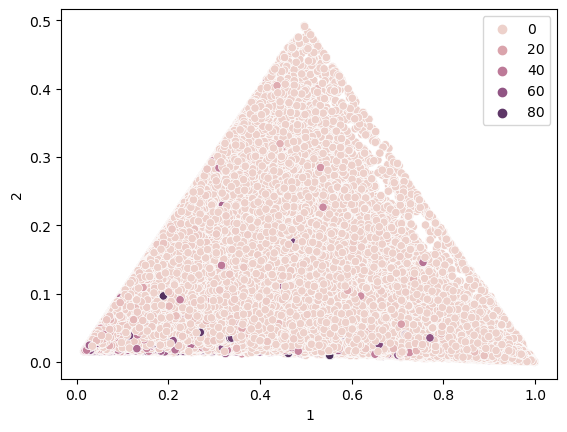

In [177]:
sns.scatterplot(data = top_values, x= '1', y='2', hue=np.abs(Y_predicted-Y_test))

/home/ubuntu/miniconda3/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/ubuntu/miniconda3/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


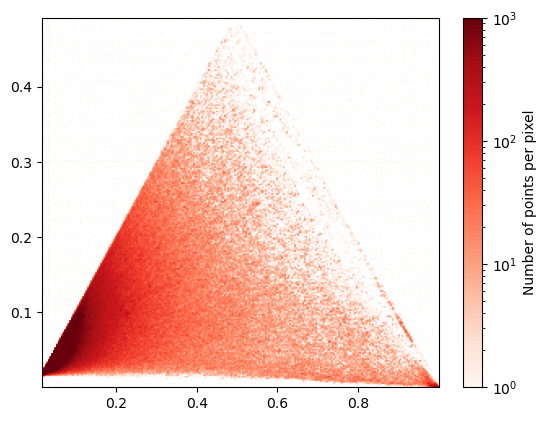

In [178]:
fig = plt.figure()
using_mpl_scatter_density(fig, top_values['1'], top_values['2'])
plt.show()

In [ ]:
sns.scatterplot(data = top_values, x= '1', y='2', hue='Z_0', size=0.001)


<Axes: xlabel='1', ylabel='2'>

## Point correctly predicted

In [ ]:
top_values_0 = top_values[top_values['Delta_Y']==0]

In [ ]:
len(top_values_0)

In [ ]:
sns.scatterplot(data = top_values_0, x= '1', y='2', hue='Z_0', )


In [ ]:
fig = plt.figure()
using_mpl_scatter_density(fig, top_values_0['1'], top_values_0['2'])
plt.show()

## Points with wrong prediction

In [ ]:
top_values_15 = top_values[top_values['Delta_Y']>=15]

In [ ]:
sns.scatterplot(data = top_values_15, x= '1', y='2', hue='alpha', )


In [ ]:
fig = plt.figure()
using_mpl_scatter_density(fig, top_values_15['1'], top_values_15['2'])
plt.show()

## Attempt of 3D plot

In [ ]:
fig=plt.figure()
ax=plt.axes(projection='3d')
ax.scatter3D(top_values_15['1'], top_values_15['2'], top_values_15['3'], s=0.01)